<a href="https://colab.research.google.com/github/BerkayYuce/football-player-market-value-prediction-model/blob/main/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1️⃣ Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math


2️⃣ Dataset & Model Class’ları

In [ ]:
class GatedResidualNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.gate = nn.Linear(output_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.norm = nn.LayerNorm(output_dim)
        self.skip_proj = nn.Linear(input_dim, output_dim) if input_dim != output_dim else None
    def forward(self, x):
        residual = x if self.skip_proj is None else self.skip_proj(x)
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        gate = self.sigmoid(self.gate(x))
        x = gate * x + (1 - gate) * residual
        return self.norm(x)

class SimpleTFT(nn.Module):
    def __init__(self, n_features, hidden_size=64, output_size=1, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(n_features, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.grn = GatedResidualNetwork(hidden_size, hidden_size, hidden_size, dropout)
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=4, dropout=dropout, batch_first=True)
        self.head = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.embedding(x)
        enc_out, _ = self.encoder(x)
        grn_out = self.grn(enc_out)
        attn_out, _ = self.attention(grn_out, grn_out, grn_out)
        pooled = attn_out.mean(dim=1)
        return self.head(pooled).squeeze(-1)

class FootballDataset(Dataset):
    def __init__(self, X, y, seq_len=5, n_features=None):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.n_features = n_features if n_features else X.shape[1] // seq_len
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x_seq = self.X[idx].reshape(self.seq_len, self.n_features)
        y_val = self.y[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping at counter {self.counter}")

def safe_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100


3️⃣ Dosya Yükle & Preprocessing (Loader’lar dahil)

In [ ]:
# Dosya yollarını kendi upload ettiğin şekilde ayarla
train = pd.read_csv('/content/train.csv')
val = pd.read_csv('/content/val.csv')
test = pd.read_csv('/content/test.csv')

target_col = 'target'
id_cols = ['Oyuncu_ID', 'Date']
seq_len = 5

# Feature seçimi
feature_cols = [c for c in train.columns if c not in [target_col] + id_cols]
feature_sets = [set([c.replace(f'_t{i}', '') for c in feature_cols if c.endswith(f'_t{i}')])
                for i in range(1, seq_len+1)]
common_features = set.intersection(*feature_sets)
common_features = sorted(common_features)

ordered_cols = [f"{f}_t{i}" for i in range(1, seq_len+1) for f in common_features]

def prepare_X_y(df):
    X = df[ordered_cols].values
    y = df[target_col].values
    return X, y

X_train, y_train = prepare_X_y(train)
X_val, y_val = prepare_X_y(val)
X_test, y_test = prepare_X_y(test)

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

dataset_train = FootballDataset(X_train_scaled, y_train_scaled, seq_len=seq_len, n_features=len(common_features))
dataset_val   = FootballDataset(X_val_scaled,   y_val_scaled,   seq_len=seq_len, n_features=len(common_features))
dataset_test  = FootballDataset(X_test_scaled,  y_test_scaled,  seq_len=seq_len, n_features=len(common_features)
)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


4️⃣ Model Kurulumu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SimpleTFT(
    n_features=len(common_features),
    hidden_size=64,
    output_size=1,
    num_layers=1,
    dropout=0.3
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=15, min_delta=0.001)

Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


5️⃣ Eğitim & Değerlendirme

In [ ]:
train_losses, val_losses = [], []
best_val_loss = float('inf')
start_train = time.time()

for epoch in range(1, 101):
    model.train()
    total_train = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_train += loss.item()
    train_loss = total_train / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    total_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_val += criterion(pred, yb).item()
    val_loss = total_val / len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopping(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_tft_model.pth')
    if epoch % 5 == 0 or epoch <= 10:
        print(f"Epoch {epoch:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

train_time = time.time() - start_train
model.load_state_dict(torch.load('best_tft_model.pth'))

# Evaluation
y_true, y_pred = [], []
model.eval()
start_inf = time.time()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())
inf_time = time.time() - start_inf

y_true_inv = scaler_y.inverse_transform(np.array(y_true).reshape(-1,1)).flatten()
y_pred_inv = scaler_y.inverse_transform(np.array(y_pred).reshape(-1,1)).flatten()

mse = mean_squared_error(y_true_inv, y_pred_inv)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)
mape = safe_mape(y_true_inv, y_pred_inv)

print("\nFinal Metrics:")
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")
print(f"Train time: {train_time:.2f}s, Inference time: {inf_time:.2f}s")


Epoch   1 | Train: 0.7223 | Val: 0.4627
Epoch   2 | Train: 0.4404 | Val: 0.3910
Epoch   3 | Train: 0.3664 | Val: 0.3794
Epoch   4 | Train: 0.3232 | Val: 0.3309
Epoch   5 | Train: 0.2824 | Val: 0.3062
Epoch   6 | Train: 0.2533 | Val: 0.2871
Epoch   7 | Train: 0.2378 | Val: 0.2600
Epoch   8 | Train: 0.2150 | Val: 0.2622
Epoch   9 | Train: 0.1966 | Val: 0.2641
Epoch  10 | Train: 0.1902 | Val: 0.2210
Epoch  15 | Train: 0.1448 | Val: 0.2391
Epoch  20 | Train: 0.1303 | Val: 0.2320
Epoch  25 | Train: 0.1134 | Val: 0.2289
Epoch  30 | Train: 0.1057 | Val: 0.2065
Epoch  35 | Train: 0.1019 | Val: 0.1894
Epoch  40 | Train: 0.1023 | Val: 0.1949
Early stopping at counter 15
Early stopping at epoch 42

Final Metrics:
MSE: 119992662097920.0000, MAE: 8040703.0000, RMSE: 10954116.2171, R2: 0.7897, MAPE: 82.59%
Train time: 32.88s, Inference time: 0.03s


6️⃣ Visualization

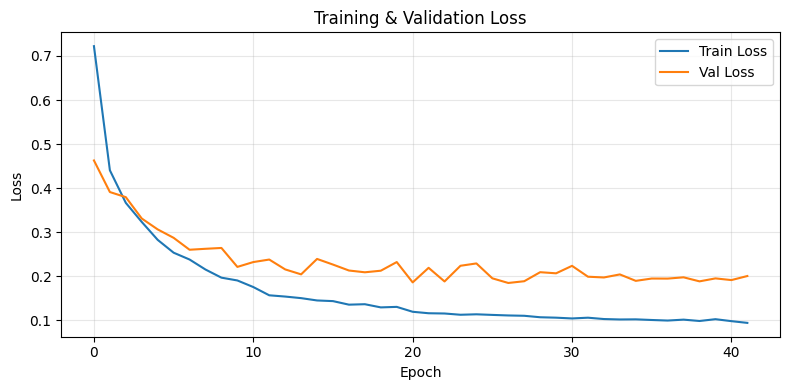

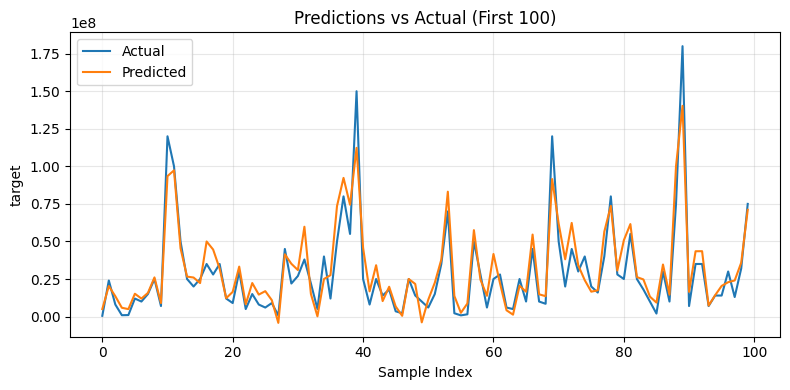

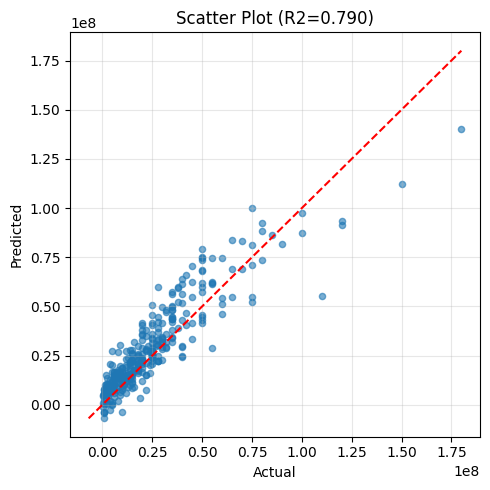

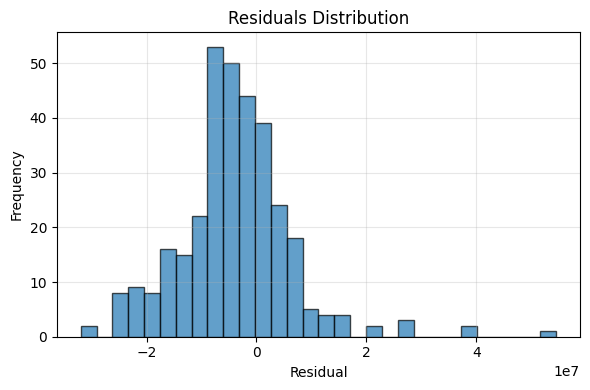

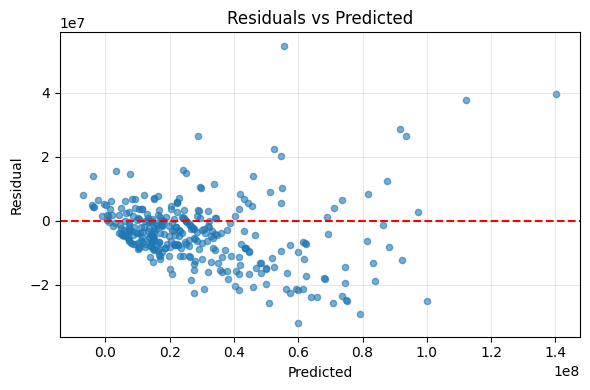

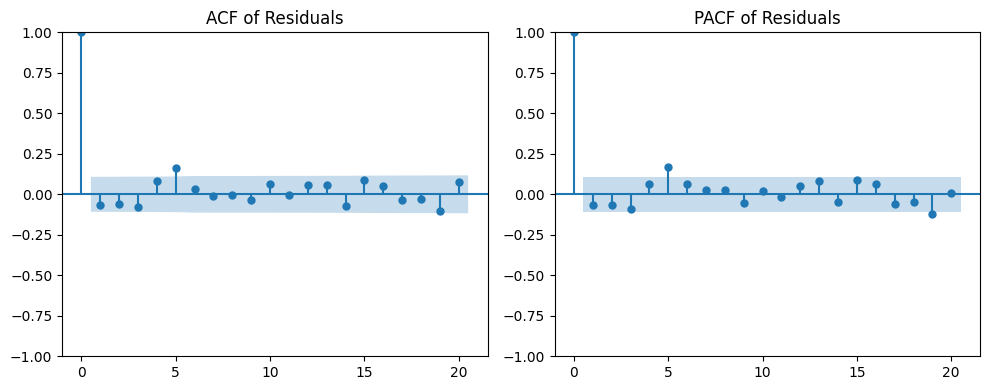

In [ ]:
# Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Predictions vs Actual (First 100)
plt.figure(figsize=(8,4))
plt.plot(y_true_inv[:100], label='Actual')
plt.plot(y_pred_inv[:100], label='Predicted')
plt.title('Predictions vs Actual (First 100)')
plt.xlabel('Sample Index')
plt.ylabel(target_col)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter Plot
plt.figure(figsize=(5,5))
plt.scatter(y_true_inv, y_pred_inv, alpha=0.6, s=20)
m, M = min(y_true_inv.min(), y_pred_inv.min()), max(y_true_inv.max(), y_pred_inv.max())
plt.plot([m,M],[m,M],'r--')
plt.title(f'Scatter Plot (R2={r2:.3f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals Distribution
residuals = y_true_inv - y_pred_inv
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred_inv, residuals, alpha=0.6, s=20)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ACF & PACF of Residuals
try:
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
    plot_acf(residuals, lags=20, ax=ax1, title='ACF of Residuals')
    plot_pacf(residuals, lags=20, ax=ax2, title='PACF of Residuals')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot ACF/PACF:", e)
